#### 对文章Mahalanobis Distance Similarity Measure Based Distinguisher for Template Attack的复现实验

In [1]:
import h5py
import numpy as np
import mlscat as cat
from tqdm import tqdm

In [2]:
with h5py.File("../datasets/data.h5", "r") as hf:
    traces = hf['traces'][()]
    plaintext = hf['plaintext'][()]
    keys = hf['keys'][()]

1.5w个兴趣点,求矩阵的逆太难了,需要预先挑选出来信噪比较高的`10`个兴趣点.

In [3]:
byte_num = 2

mid_values = np.empty(shape=(1800, 1), dtype=np.uint16)
for num in range(1800):
    mid_values[num] = cat.utils.get_mid(plaintext[num][byte_num], keys[num][byte_num], mask=-1, mask_scheme='None')

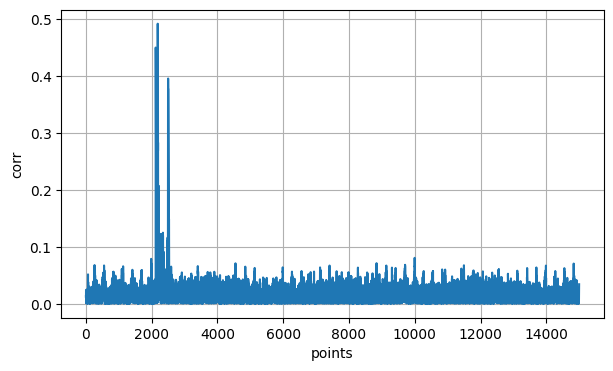

In [4]:
traces_pcc = cat.attacks.pcc(mid_values, traces[:1800])
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(traces_pcc)
plt.xlabel("points")
plt.ylabel("corr")
plt.grid()
plt.show()

In [5]:
# 获取前十最大相关性的点的索引
num_poi = 10
sorted_indices = np.argsort(traces_pcc)[::-1]
top_indices = sorted_indices[:num_poi]

In [6]:
profiling_traces = traces[:-200, top_indices]
profiling_plaintext = plaintext[:-200]
profiling_keys = keys[:-200]

attack_traces = traces[-200:, top_indices]
attack_plaintext = plaintext[-200:]

In [7]:
import os

folder = os.path.exists("./template_data")
if not folder:
    os.makedirs("./template_data")
    
for i in range(256):
    indices = np.where(np.array(mid_values) == i)[0]
    class_traces = [profiling_traces[j] for j in indices]
    class_plaintext = [profiling_plaintext[j] for j in indices]
    class_keys = [profiling_keys[j] for j in indices]
    
    np.savetxt(f"./template_data/traces_{i}.txt", class_traces)
    np.savetxt(f"./template_data/plaintext_{i}.txt", class_plaintext)
    np.savetxt(f"./template_data/keys_{i}.txt", class_keys)
    

#### 建模

In [10]:
def get_mean_and_cov(i):
    i_class_traces = np.loadtxt(f"./template_data/traces_{i}.txt")
    vec_m = np.mean(i_class_traces, axis=0)
    centered_traces = i_class_traces - vec_m
    vec_C = np.cov(centered_traces, rowvar=False)
    return vec_m, vec_C, i_class_traces.shape[0]

In [12]:
sum_C_i = np.zeros(shape=(10, 10))
for i in range(256):
    _, vec_C, n_i = get_mean_and_cov(i)
    sum_C_i += n_i * vec_C
C_0 = sum_C_i / 256

In [ ]:
distancs_list = []
for ts in tqdm(range(256)):
    tmp_prob = 0
    for i in range(attack_traces.shape[0]):
        targets = cat.utils.AES_Sbox[attack_plaintext[i][byte_num] ^ ts]
        vec_m, vec_C, _ = get_mean_and_cov(targets)
        # TODO: 数据量大了这个if就不要了
        if vec_C.shape != (num_poi, num_poi):
            omd = 0
        else:
            # 这里矩阵可能会不可逆, 下位代替求伪逆矩阵
            # omd = (attack_traces[i] - vec_m).T @ np.linalg.pinv(vec_C) @ (attack_traces[i] - vec_m)
            omd = (attack_traces[i] - vec_m).T @ np.linalg.pinv(C_0) @ (attack_traces[i] - vec_m)
        tmp_prob += omd
    distancs_list.append(tmp_prob)

100%|██████████| 256/256 [00:08<00:00, 28.52it/s]


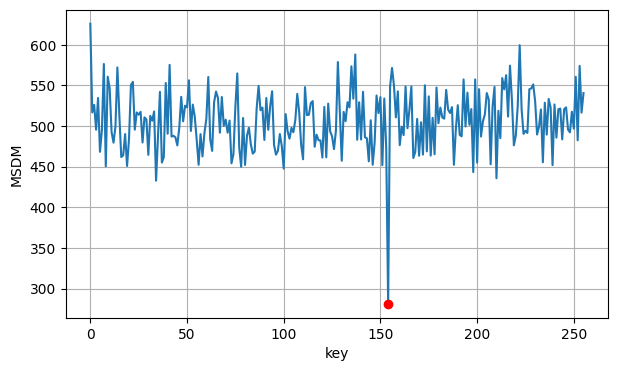

In [14]:
guess_idx = np.argmin(distancs_list)

plt.figure(figsize=(7,4))
plt.plot(distancs_list)
plt.plot(guess_idx, distancs_list[guess_idx], 'ro')
plt.xlabel("key")
plt.ylabel("MSDM")
plt.grid()
plt.show()

In [11]:
f"the correct key(byte2) is: {keys[0][2]}, the gussed key is : {guess_idx}"

'the correct key(byte2) is: 154, the gussed key is : 154'